# Beer Production in Austria

### Observación de los datos

Se va a proceder al estudio y predicción de la serie temporal referente a la producción de cerveza en Austria. Dentro del dataset proporcionado se obtienen 476 datos temporales mensuales y dos columnas, una para el mes y otra para el número de cervezas producidas.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from neuralprophet import NeuralProphet

c:\Users\Russhi\Desktop\BOOTCAMP\venv_analytics\lib\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [23]:
df = pd.read_csv('https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv')
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


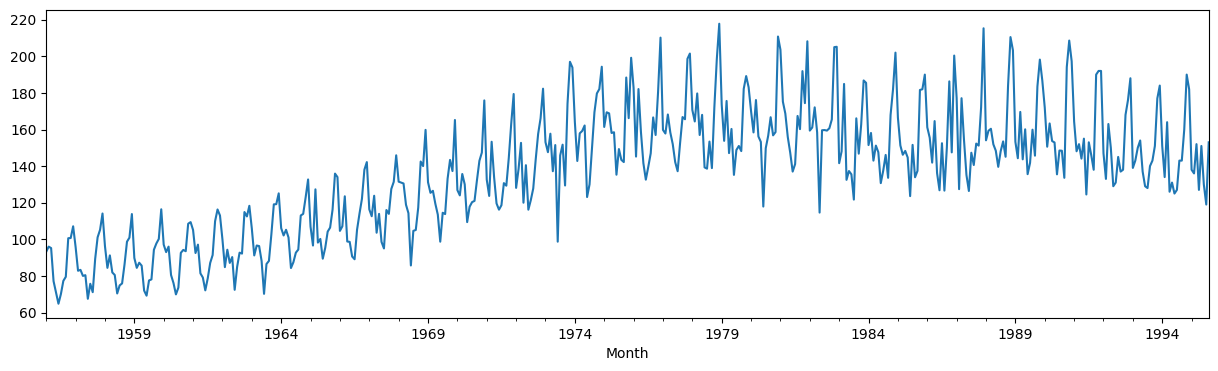

In [24]:
series=df['Monthly beer production']
series.plot(figsize=(15,4))
plt.show()

### Estacionariedad

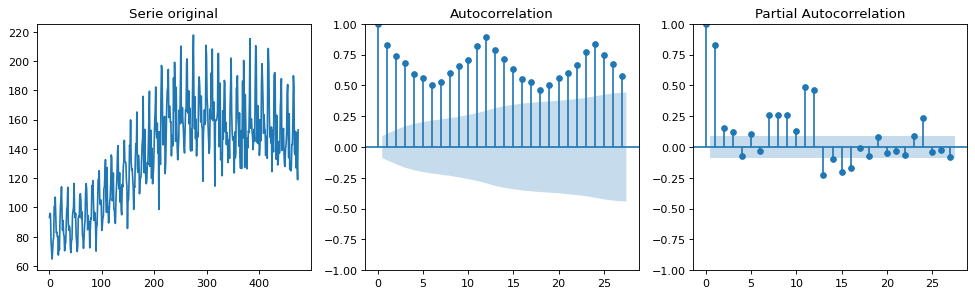

In [25]:
# Creamos gráfico
f = plt.figure(figsize=(15, 4), dpi=80)
# Preparamos primer componente
ax1 = f.add_subplot(131)
ax1.set_title('Serie original')
ax1.plot(series.values)
# Preparamos segundo componente
ax2 = f.add_subplot(132)
plot_acf(series.values, ax=ax2)
# Preparamos tercer componente
ax3 = f.add_subplot(133)
plot_pacf(series.values, ax=ax3)
plt.show()

In [26]:
month_num = 12
rolling_mu = df.rolling(month_num).mean()
rolling_sigma = df.rolling(month_num).std()

Text(0.5, 1.0, 'Beer Production Time Series, Rolling Mean, Standard Deviation')

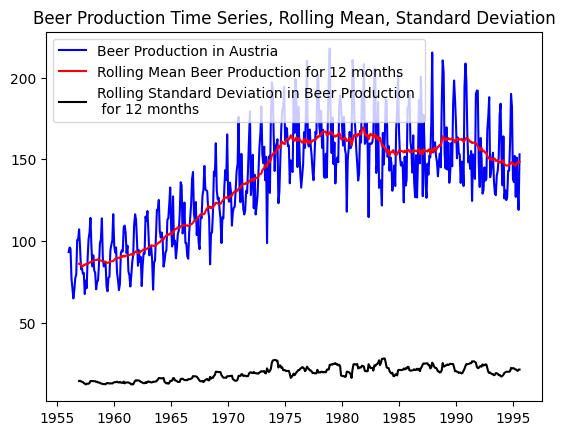

In [27]:
plt.plot(df, color="blue",label="Beer Production in Austria")

plt.plot(rolling_mu, color="red", label= f"Rolling Mean Beer Production for {month_num} months")

plt.plot(rolling_sigma, color="black", label = f"Rolling Standard Deviation in Beer Production \n for {month_num} months")

plt.legend(loc = "best")

plt.title("Beer Production Time Series, Rolling Mean, Standard Deviation")

In [28]:
for i in range(3,26,3):
    autocorrelation = df["Monthly beer production"].autocorr(lag = i)
    print(f"La autocorrelación para {i} meses es {autocorrelation}")

La autocorrelación para 3 meses es 0.6854732857374352
La autocorrelación para 6 meses es 0.5165232615479778
La autocorrelación para 9 meses es 0.6814094319691515
La autocorrelación para 12 meses es 0.9316478763539178
La autocorrelación para 15 meses es 0.6604935420696462
La autocorrelación para 18 meses es 0.4883164150324921
La autocorrelación para 21 meses es 0.6462425346415905
La autocorrelación para 24 meses es 0.9011564388811296


Se observa en la serie una periodicidad cada 12 meses, indicando estaciones de producción máxima y mínima.

### Descomposición

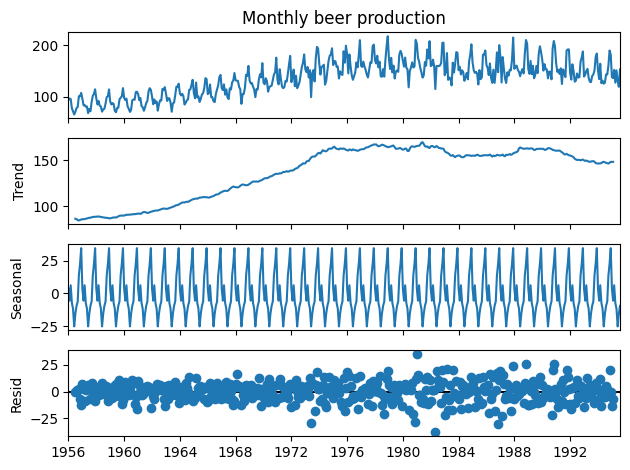

In [29]:
descomp = seasonal_decompose(df["Monthly beer production"], period = 12)
descomp.plot()
plt.show()

Se observa una tendencia de crecimiento que se ha estabilizado a partir de 1975 aproximádamente y periodos de produción máxima y mínima en cada estación del año (aproximadamente cada 3 o 4 meses se produce un pico).

### Forecasting

In [30]:
df['Month'] = df.index
train = df[df['Month'] < pd.to_datetime("1985-12", format='%Y-%m')] # Separamos train hasta el agosto de 1960
train['train'] = train["Monthly beer production"]
del train['Month']
del train["Monthly beer production"]
train

C:\Users\Russhi\AppData\Local\Temp\ipykernel_13196\550259917.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train["Monthly beer production"]


,train
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1985-07-01,151.6
1985-08-01,133.9
1985-09-01,137.4


In [31]:
# Dataframe de testeo
test = df[df['Month'] >= pd.to_datetime("1985-12", format='%Y-%m')]
del test['Month']
test['test'] = test["Monthly beer production"]
del test["Monthly beer production"]
test

C:\Users\Russhi\AppData\Local\Temp\ipykernel_13196\3417592334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test["Monthly beer production"]


,test
Month,
1985-12-01,190.0
1986-01-01,161.2
1986-02-01,155.5
1986-03-01,141.9
1986-04-01,164.6
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


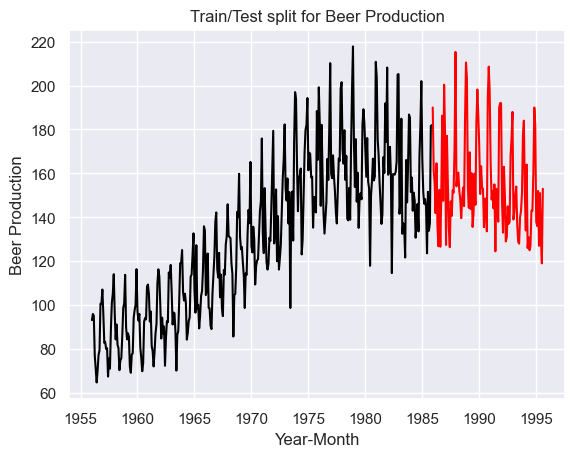

In [38]:
# Visualizar datos de entrenamiento vs datos de testeo
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Beer Production")
plt.ylabel("Beer Production")
plt.xlabel('Year-Month')
sns.set()
plt.show()

Se utiliza el modelo auto-ARIMA para la predicción de la serie temporal.

In [36]:
# Buscamos los mejores parámetros para el modelo ARIMA
model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
model.fit(train)
# Creamos predicciones sobre el modelo entrenado
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
forecast

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2963.296, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2828.796, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2576.932, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2705.150, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2575.414, Time=0.48 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2660.639, Time=0.15 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2572.173, Time=1.05 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2633.679, Time=0.55 sec
 ARIMA(0,1,1)(3,1,1)[12]             : AIC=2566.213, Time=2.31 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=2607.626, Time=1.17 sec
 ARIMA(0,1,1)(4,1,1)[12]             : AIC=2554.978, Time=3.05 sec
 ARIMA(0,1,1)(4,1,0)[12]             : AIC=2569.198, Time=2.26 sec
 ARIMA(0,1,1)(5,1,1)[12]             : AIC=2552.404, Time=9.96 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=2551.393, Time=8.74 sec
 ARIMA(0,1,0)(5,1,0

,Prediction
Month,
1985-12-01,194.416185
1986-01-01,170.438553
1986-02-01,156.482224
1986-03-01,161.614836
1986-04-01,147.842352
...,...
1995-04-01,133.562522
1995-05-01,126.440589
1995-06-01,118.883548


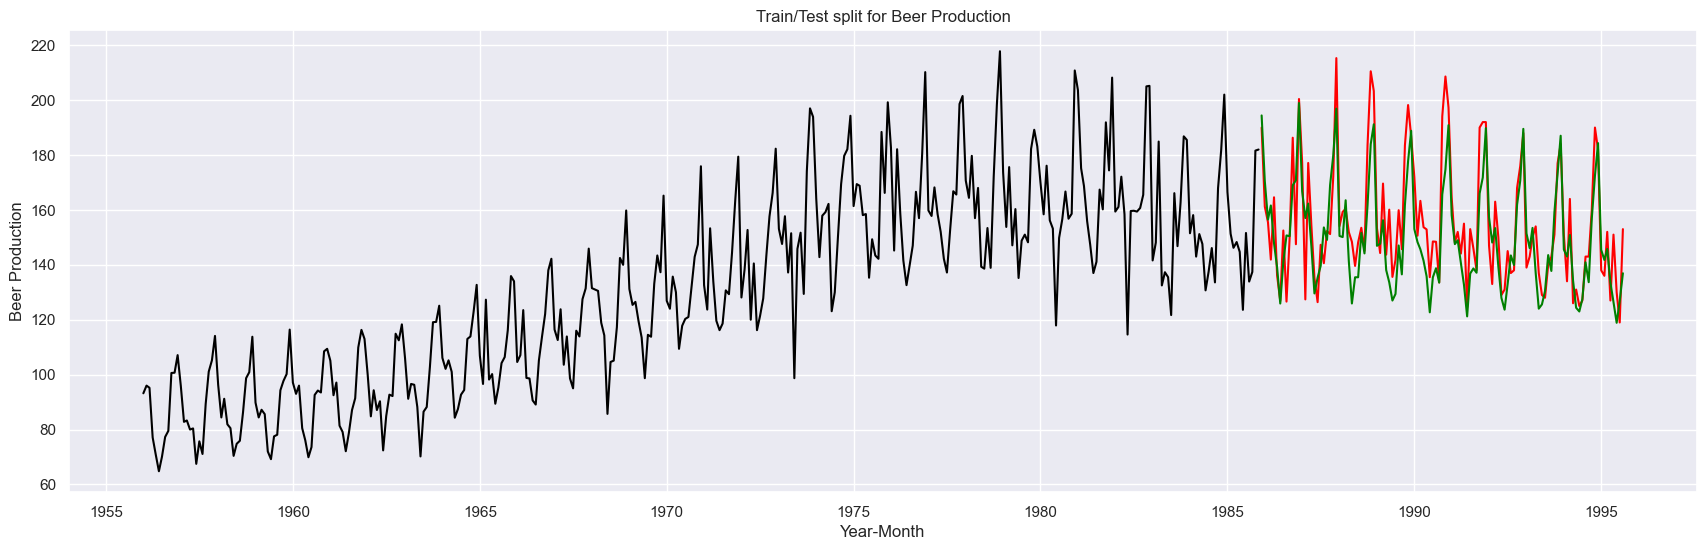

In [37]:
forecast# Visualizar datos de entrenamiento vs datos de testeo vs el forecast
plt.figure(figsize=(21,6))
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast, color = "green")

plt.title("Train/Test split for Beer Production")
plt.ylabel("Beer Production")
plt.xlabel('Year-Month')
sns.set()
plt.show()

Se observa que la predicción de los datos a través del modelo ARIMA consigue ajustarse de forma satisfactoria al modelo.

### Métrica de conclusión

In [39]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test,forecast['Prediction']))
print("RMSE: ", rms)

RMSE:  12.51591250201746


Se obtiene una diferencia entre el valor real y predicho menor al 10%, por lo que se ha conseguido un modelo que consigue predecir los datos de manera satisfactoria.

### NeuralProphet para predicción de datos futuros

In [40]:
df = pd.read_csv('https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv')
df.rename(columns = {'Month':'ds', 'Monthly beer production':'y'}, inplace = True)
df['ds'] = pd.DatetimeIndex(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      476 non-null    datetime64[ns]
 1   y       476 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


In [42]:
asd = np.array([0,1])

In [ ]:
# Instanciamos clase
m = NeuralProphet()
# Partimos datos especificando unidad mínima de tiempo
df_train, df_val = m.split_df(df, freq='M', valid_p = 0.2)
# Entrenamos modelo
metrics = m.fit(df_train, freq='M', validation_df=df_val)

* Observamos los errores en el análisis:

<Axes: >

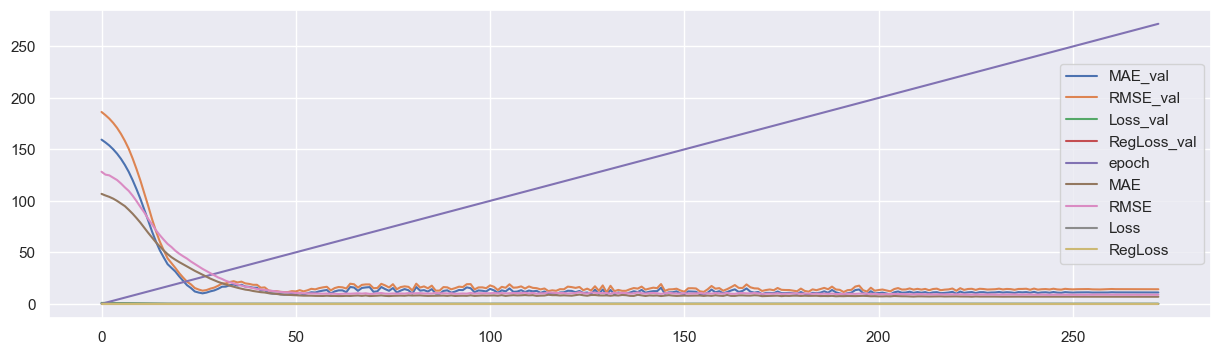

In [44]:
metrics.plot(figsize=(15,4))

* Realizamos la predicción futura

In [45]:
future = m.make_future_dataframe(df, periods=24, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.79]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.8]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.8]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 24it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [46]:
forecast['residual1']=None
for i in forecast.index:
    forecast.loc[i,'residual1']=forecast.loc[i,'y']-forecast.loc[i,'yhat1']

In [47]:
forecast.head()

,ds,y,yhat1,trend,season_yearly,residual1
0,1956-01-01,93.2,92.283615,86.940430,5.343185,0.916385
1,1956-02-01,96.0,83.098656,86.941422,-3.842766,12.901344
2,1956-03-01,95.2,94.073326,86.942345,7.130983,1.126674
3,1956-04-01,77.1,79.493187,86.943336,-7.450150,-2.393187
4,1956-05-01,70.9,75.110275,86.944290,-11.834011,-4.210275


* Observamos los datos finales:

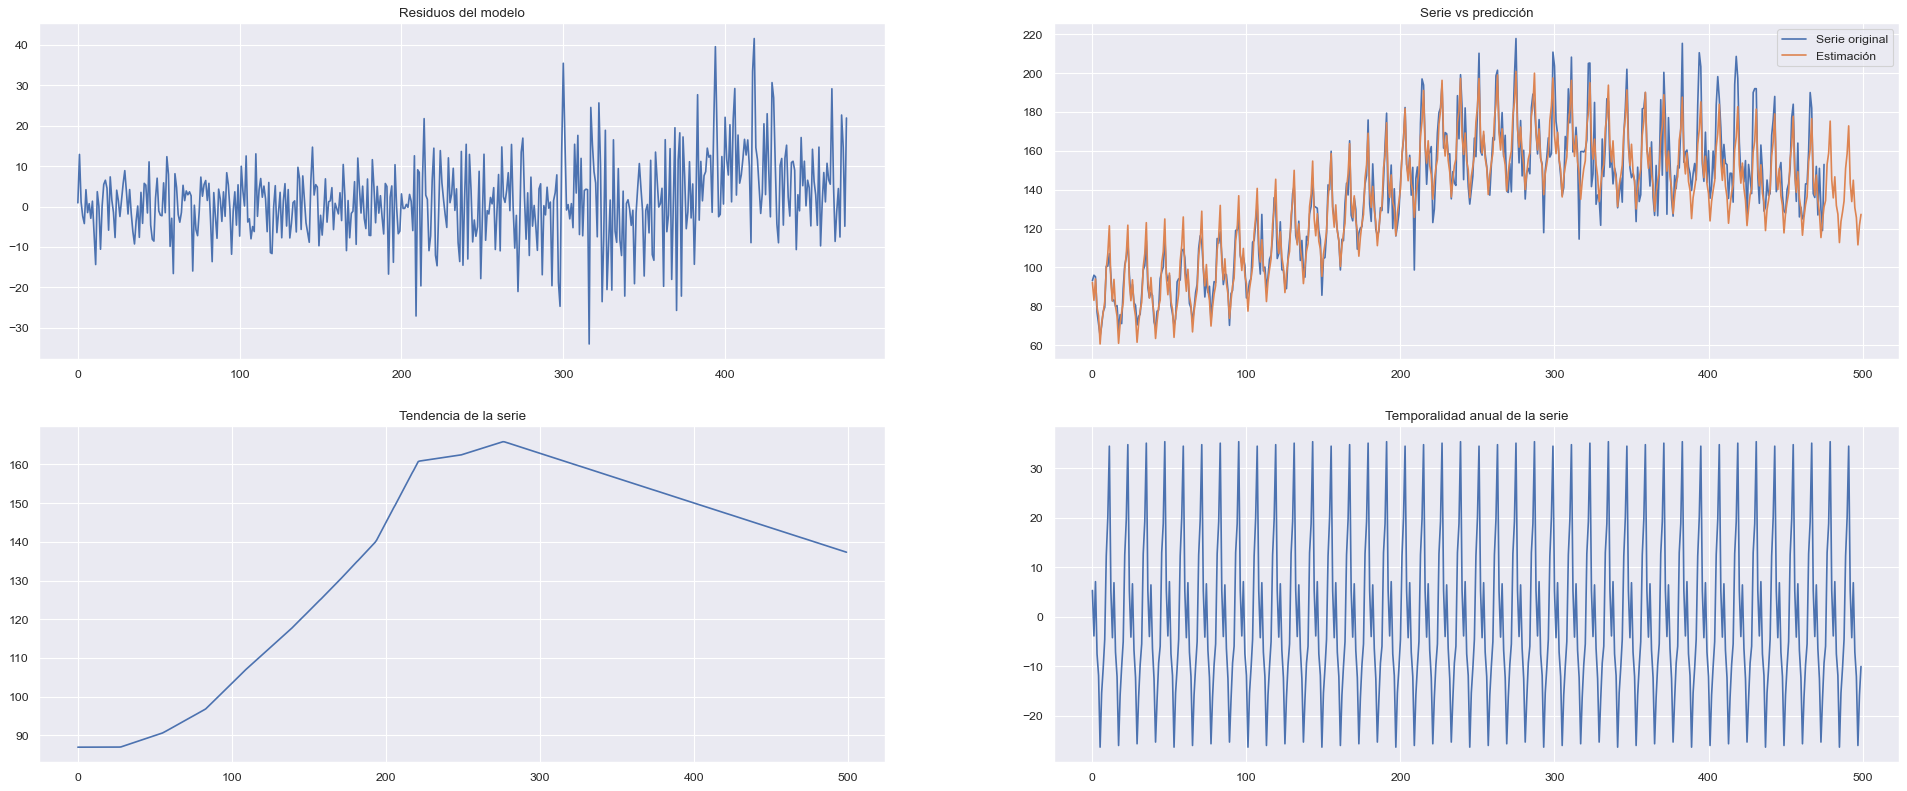

In [51]:
# Creamos gráfico
f = plt.figure(figsize=(30, 12), dpi=80)
# Preparamos primer componente - Diferencia entre el actual y predicho
ax1 = f.add_subplot(221)
ax1.set_title('Residuos del modelo')
ax1.plot(forecast['residual1'])
# Preparamos segundo componente
ax2 = f.add_subplot(222)
ax2.set_title('Serie vs predicción')
ax2.plot(forecast['y'])
ax2.plot(forecast['yhat1'])
ax2.legend(['Serie original', 'Estimación'])
# Preparamos tercer componente
ax3 = f.add_subplot(223)
ax3.set_title('Tendencia de la serie')
ax3.plot(forecast['trend'])
# Preparamos cuarto componente
ax4 = f.add_subplot(224)
ax4.set_title('Temporalidad anual de la serie')
ax4.plot(forecast['season_yearly'])

Se observa que se ha conseguido realizar la predicción con un error mínimo.